In [1]:
from squlearn.feature_map.qcnn_feature_map import qcnn_feature_map
from squlearn.feature_map.qcnn_feature_map import prototype_routine
from squlearn.util import Executor
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
import numpy as np
import itertools
import random
from squlearn.expectation_operator import SingleAmplitude
from squlearn.qnn import QNN
from squlearn.feature_map.layered_feature_map import LayeredFeatureMap
from qiskit.primitives import Estimator
from squlearn.qnn.training import regression
from squlearn.optimizers import SLSQP,Adam
from squlearn.qnn.loss import SquaredLoss
from squlearn.qnn.qnnr import QNNRegressor

In [2]:
def generate_data_all_combi(length):
    """Creates a 2 dimensional numpy array with all combinations of zeros and ones.
      It outputs this with there labels (0 if more zeros than ones, 1 else)"""
    all_combi_list = list(itertools.product([0,1],repeat=length))
    X_tuple_list = all_combi_list
    X = np.array(X_tuple_list)  #converts list of tuples into a numpy array with dimension 2
    Y = np.count_nonzero(X==0,axis=1) #counts the number of zeros in each sublist
    for i in range(len(Y)):
        zeros = Y[i]
        if 2*zeros > length:
            Y[i] = 0
        else:
            Y[i] = 1 
    return X,Y

def generate_train_data(all_combination_data,train_size):
    """Generates from given all_combination data a train set with there labels."""
    X,Y = all_combination_data[0],all_combination_data[1]
    data_size = Y.size
    index_list = range(data_size)
    index_choice = random.sample(index_list, train_size)
    X_train = np.array([X[i] for i in index_choice])
    Y_train = np.array([Y[i] for i in index_choice])
    return X_train, Y_train



In [3]:
qubits = 6
train_set_size = 32
#-------------------------------------------------------------------------------------------------------------------------------------------

21


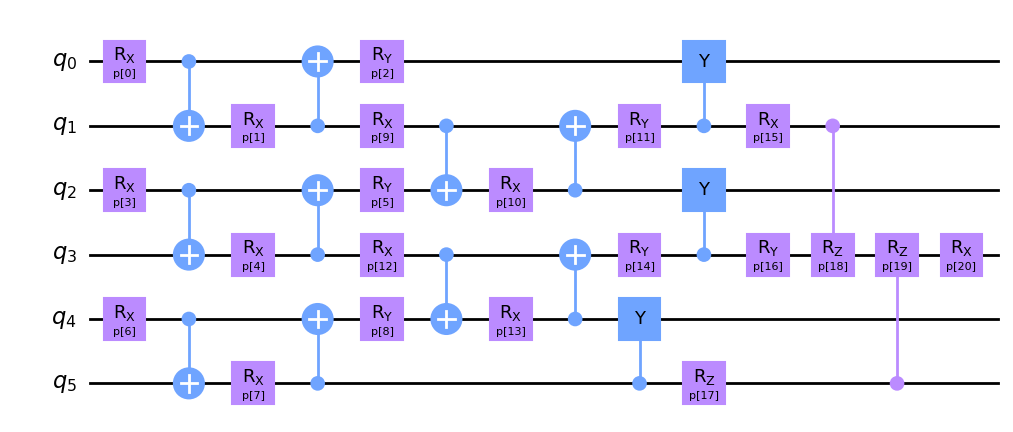

In [4]:
"""
#QCNN feature map with no controlled rotation in convolution layer but with cx for entangling, in fully connected: every qubit rotates differently
qcnn_train = qcnn_feature_map(qubits)

x = ParameterVector("x",6)
conv_gate1 = QuantumCircuit(2)
conv_gate1.rx(x[0],0)
conv_gate1.cx(0,1)
conv_gate1.rx(x[1],1)
conv_gate1.cx(1,0)
conv_gate1.ry(x[2],0)

pool_gate = QuantumCircuit(2)
pool_gate.cy(1,0)

f = ParameterVector("f",6)
fully_gate = QuantumCircuit(3)
fully_gate.rx(f[0],0)
fully_gate.ry(f[1],1)
fully_gate.rz(f[2],2)
fully_gate.crz(f[3],0,1)
fully_gate.crz(f[4],2,1)
fully_gate.rx(f[5],1)

qcnn_train.convolution(conv_gate1,entangled=True,var_param=True)
qcnn_train.pooling(pool_gate)
qcnn_train.fully_connected(fully_gate)

param_vec_for_qcnn = ParameterVector("p", qcnn_train.num_parameters)
qcnn_train.get_circuit([],param_vec_for_qcnn).draw()
#qcnn_train.get_circuit([],param_vec_for_qcnn).decompose().draw()
"""
# train_qcnn_different_rotations_variation_in_entangling_64_data_points
#-------------------------------------------------------------------------------------------------------------------------------------------
#QCNN feature map with no controlled rotation in convolution layer but with cx for entangling, in fully connected: every qubit rotates differently
qcnn_train = qcnn_feature_map(qubits)

x = ParameterVector("x",6)
conv_gate1 = QuantumCircuit(2)
conv_gate1.rx(x[0],0)
conv_gate1.cx(0,1)
conv_gate1.rx(x[1],1)
conv_gate1.cx(1,0)
conv_gate1.ry(x[2],0)

pool_gate = QuantumCircuit(2)
pool_gate.cy(1,0)

f = ParameterVector("f",6)
fully_gate = QuantumCircuit(3)
fully_gate.rx(f[0],0)
fully_gate.ry(f[1],1)
fully_gate.rz(f[2],2)
fully_gate.crz(f[3],0,1)
fully_gate.crz(f[4],2,1)
fully_gate.rx(f[5],1)

qcnn_train.convolution(conv_gate1,entangled=True,var_param=True)
qcnn_train.pooling(pool_gate)
qcnn_train.fully_connected(fully_gate)

param_vec_for_qcnn = ParameterVector("p", qcnn_train.num_parameters)
print(qcnn_train.num_parameters)
qcnn_train.get_circuit([],param_vec_for_qcnn).decompose().draw()
#-------------------------------------------------------------------------------------------------------------------------------------------



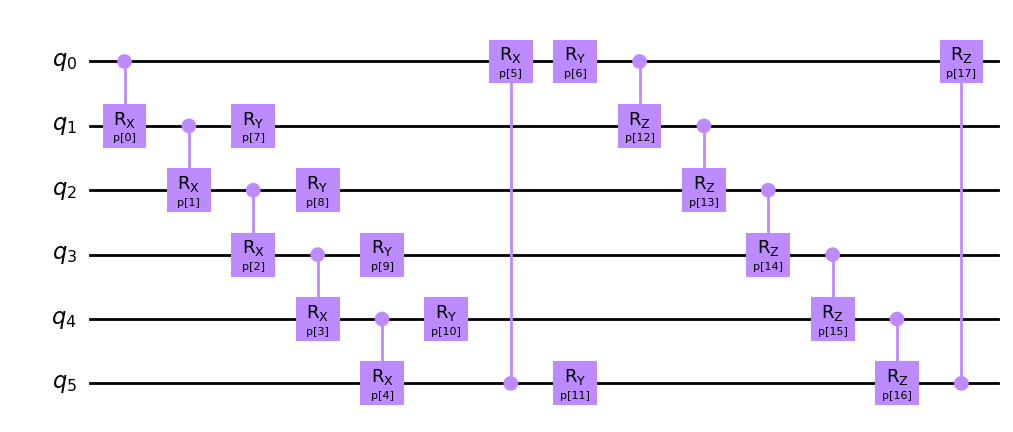

In [10]:
#-------------------------------------------------------------------------------------------------------------------------------------------
# QCNN only with fully connected layer (so it's a qnn):
qcnn_train = qcnn_feature_map(6)
x = ParameterVector("x",18)
fully_gate = QuantumCircuit(6)
fully_gate.crx(x[0],0,1)
fully_gate.crx(x[1],1,2)
fully_gate.crx(x[2],2,3)
fully_gate.crx(x[3],3,4)
fully_gate.crx(x[4],4,5)
fully_gate.crx(x[5],5,0)

fully_gate.ry(x[6],0)
fully_gate.ry(x[7],1)
fully_gate.ry(x[8],2)
fully_gate.ry(x[9],3)
fully_gate.ry(x[10],4)
fully_gate.ry(x[11],5)

fully_gate.crz(x[12],0,1)
fully_gate.crz(x[13],1,2)
fully_gate.crz(x[14],2,3)
fully_gate.crz(x[15],3,4)
fully_gate.crz(x[16],4,5)
fully_gate.crz(x[17],5,0)

qcnn_train.fully_connected(fully_gate)
param_vec_for_qcnn = ParameterVector("p", qcnn_train.num_parameters)
qcnn_train.get_circuit([],param_vec_for_qcnn).decompose().draw()
#-------------------------------------------------------------------------------------------------------------------------------------------

8
8
11
16


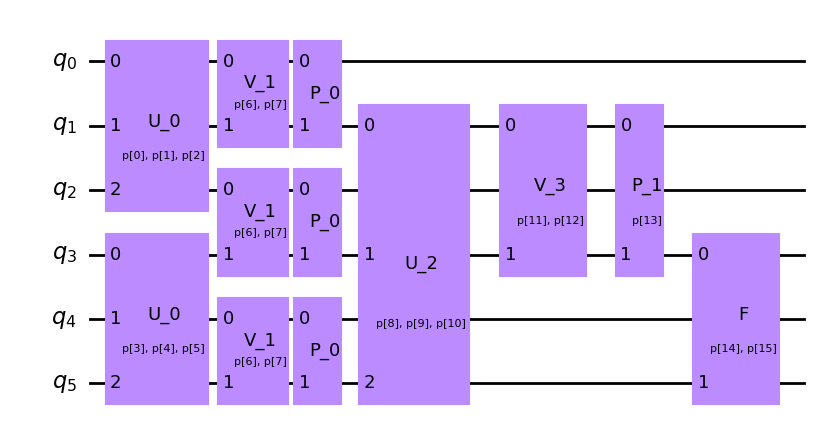

In [6]:
#2d-3d-var_param
#-------------------------------------------------------------------------------------------------------------------------------------------
# QCNN feature map with 2 and 3 qubit gates and some parameter variations (like in one gate operation the parameters of two different similar gates are different)
qcnn_train = qcnn_feature_map(6)

x = ParameterVector("x", 3)
gate_qc = QuantumCircuit(3)
gate_qc.crx(x[0],0,1)
gate_qc.crx(x[2],0,2)
gate_qc.crx(x[1],1,2)

y = ParameterVector("y", 2)
gate_conv2 = QuantumCircuit(2)
gate_conv2.crz(y[0],0,1)
gate_conv2.crz(y[1],1,0)

pooling_gate1 = QuantumCircuit(2)
pooling_gate1.cx(0,1)

z = ParameterVector("z",1)
pooling_gate2 = QuantumCircuit(2)
pooling_gate2.cry(z[0],0,1)

# Fully für 2 Qubits
a = ParameterVector("a",2)
fully_gate = QuantumCircuit(2)
fully_gate.crx(a[0],0,1)
fully_gate.crx(a[1],1,0)

#Fully für 3 Qubits
b = ParameterVector("b",3)
fully_gate2 = QuantumCircuit(3)
fully_gate2.rx(b[0],0)
fully_gate2.rx(b[1],2)
fully_gate2.rx(b[2],1)

qcnn_train.convolution(gate_qc, entangled=False,operator="U",var_param = True)
qcnn_train.convolution(gate_conv2, entangled=False,operator="V",var_param = False)
print(qcnn_train.num_parameters)

qcnn_train.pooling(pooling_gate1,operator="P",var_param=True)
print(qcnn_train.num_parameters)


qcnn_train.convolution(gate_qc, entangled=False,operator="U",var_param = True)
print(qcnn_train.num_parameters)
qcnn_train.convolution(gate_conv2, entangled=False,operator="V",var_param = False)

qcnn_train.pooling(pooling_gate2,operator="P",var_param=True)
qcnn_train.fully_connected(fully_gate)
#print(qcnn_train.get_qubits_left())
param_vec_for_qcnn = ParameterVector("p", qcnn_train.num_parameters) # TODO: num_parameter wird noch falsch berechnet
print(qcnn_train.num_parameters)
qcnn_train.get_circuit([],param_vec_for_qcnn).draw()
#-------------------------------------------------------------------------------------------------------------------------------------------

28


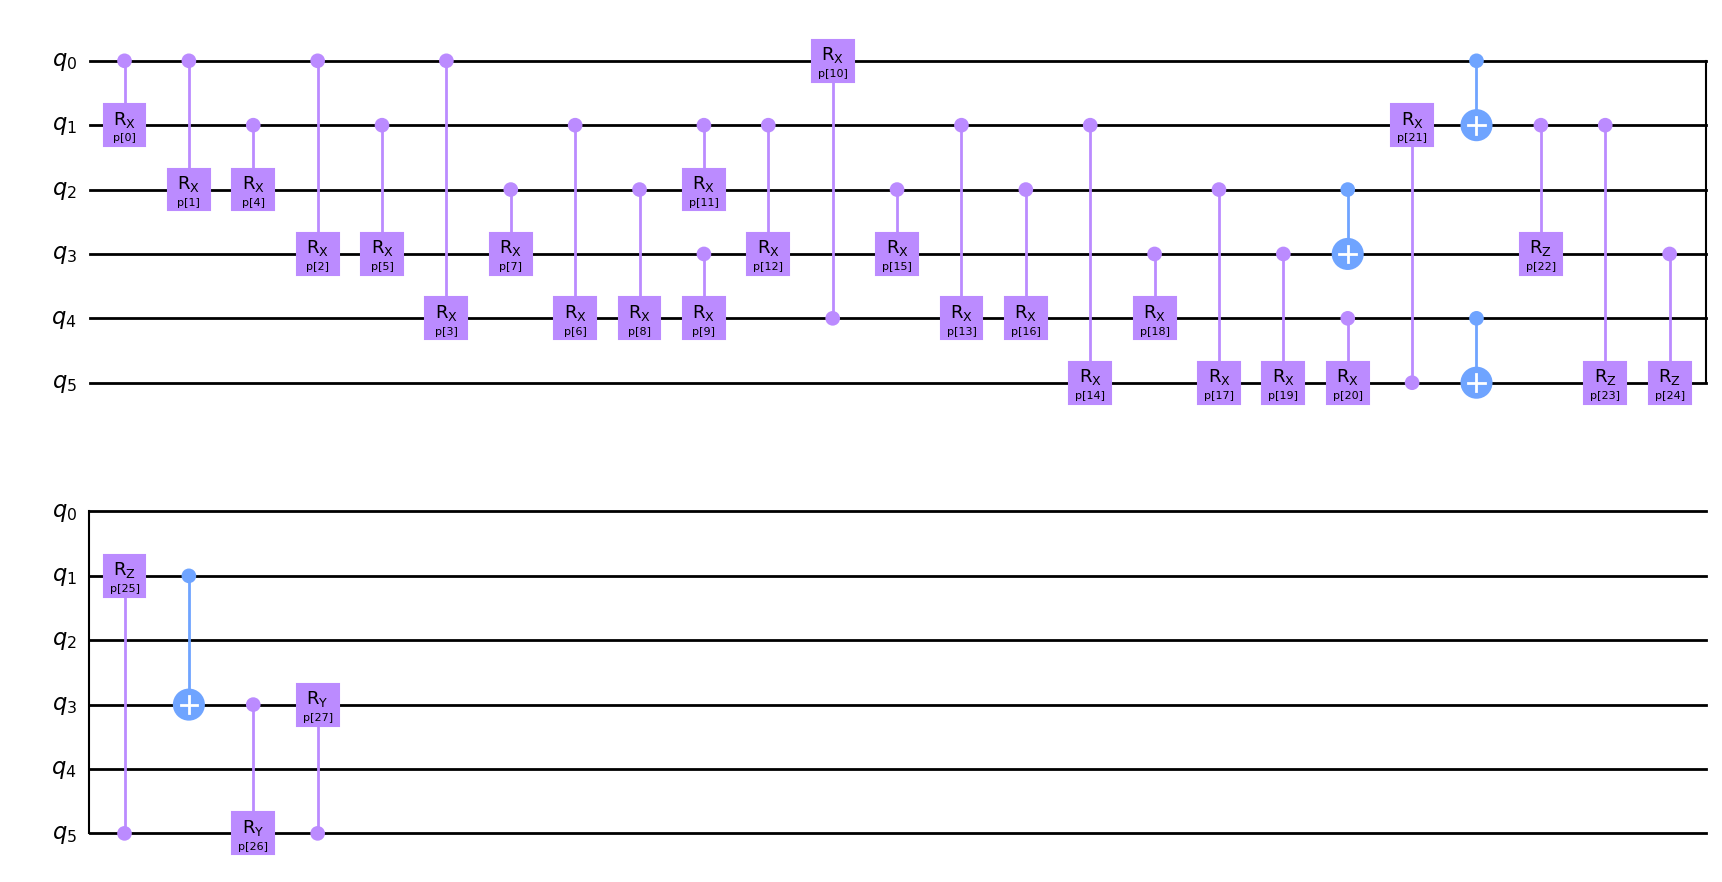

In [7]:
#pseudo AA entangling (passender num_param aber Fehlermeldung)
#-------------------------------------------------------------------------------------------------------------------------------------------
#QCNN feature map with one 5 gate convolution layer with a pseudo all in all entangling
qcnn_train = qcnn_feature_map(qubits)

x = ParameterVector("x",11)
conv_gate1 = QuantumCircuit(5)
conv_gate1.crx(x[0],0,1)
conv_gate1.crx(x[1],0,2)
conv_gate1.crx(x[2],0,3)
conv_gate1.crx(x[3],0,4)
conv_gate1.crx(x[4],1,2)
conv_gate1.crx(x[5],1,3)
conv_gate1.crx(x[6],1,4)
conv_gate1.crx(x[7],2,3)
conv_gate1.crx(x[8],2,4)
conv_gate1.crx(x[9],3,4)
conv_gate1.crx(x[10],4,0)

pool_gate = QuantumCircuit(2)
pool_gate.cx(0,1)

z = ParameterVector("z",7)
conv_gate2 = QuantumCircuit(3)
conv_gate2.crz(z[0],0,1)
conv_gate2.crz(z[1],0,2)
conv_gate2.crz(z[2],1,2)
conv_gate2.crz(z[3],2,0)

fully_gate = QuantumCircuit(2)
fully_gate.cry(z[4],0,1)
fully_gate.cry(z[5],1,0)

qcnn_train.convolution(conv_gate1,entangled=True,var_param=True)
qcnn_train.pooling(pool_gate)
qcnn_train.convolution(conv_gate2)
qcnn_train.pooling(pool_gate)
qcnn_train.fully_connected(fully_gate)

param_vec_for_qcnn = ParameterVector("p", qcnn_train.num_parameters)
print(qcnn_train.num_parameters)
qcnn_train.get_circuit([],param_vec_for_qcnn).decompose().draw()
#-------------------------------------------------------------------------------------------------------------------------------------------

10
10
12
14


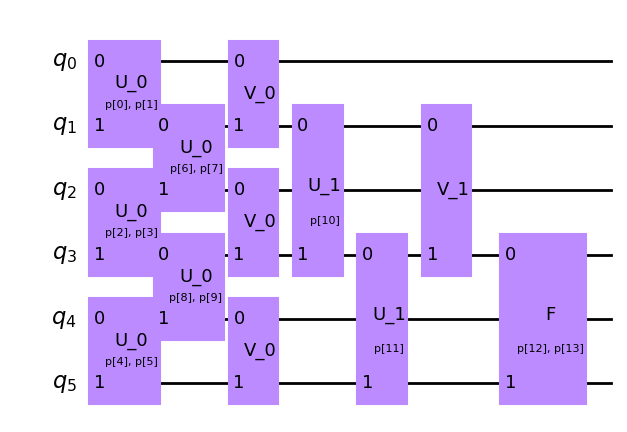

In [8]:
#-------------------------------------------------------------------------------------------------------------------------------------------
#QCNN:  crx with var_param, cry with var_param, after pool: cry with var_param
qcnn_train = qcnn_feature_map(qubits)

x = ParameterVector("x",2)
conv_gate1 = QuantumCircuit(2)
conv_gate1.crx(x[0],0,1)
conv_gate1.crz(x[1],1,0)
pool_gate = QuantumCircuit(2)
pool_gate.cx(0,1)
y = ParameterVector("y",1)
conv_gate2 = QuantumCircuit(2)
conv_gate2.cry(y[0],1,0)
z = ParameterVector("z",2)
fully_gate = QuantumCircuit(2)
fully_gate.crx(z[0],0,1)
fully_gate.cry(z[1],1,0)
qcnn_train.convolution(conv_gate1,entangled=True,var_param=True)
print(qcnn_train.num_parameters)
qcnn_train.pooling(pool_gate)
print(qcnn_train.num_parameters)
qcnn_train.convolution(conv_gate2,entangled=True,var_param=True)
print(qcnn_train.num_parameters)
qcnn_train.pooling(pool_gate)

qcnn_train.fully_connected(fully_gate)

param_vec_for_qcnn = ParameterVector("p", qcnn_train.num_parameters) # TODO: Falsche Params
print(qcnn_train.num_parameters)
qcnn_train.get_circuit([],param_vec_for_qcnn).draw()
#-------------------------------------------------------------------------------------------------------------------------------------------

12


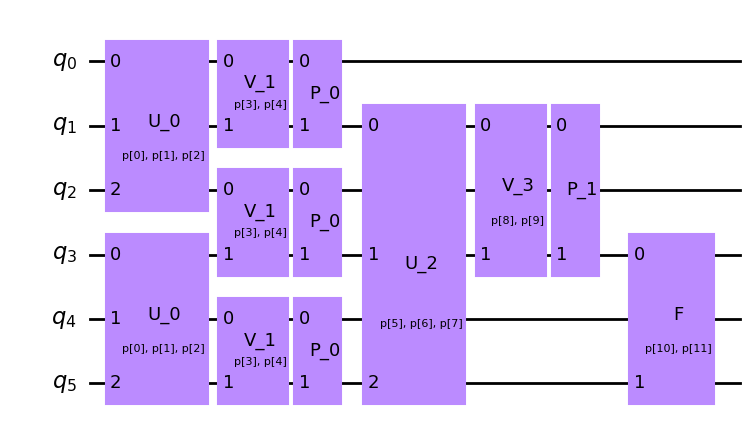

In [9]:
# David's example
qcnn_train = qcnn_feature_map(qubits)
x = ParameterVector("x", 3)
gate_qc = QuantumCircuit(3)
gate_qc.crx(x[0],0,1)
gate_qc.crx(x[2],0,2)
gate_qc.crx(x[1],1,2)
y = ParameterVector("y", 2)
gate_conv2 = QuantumCircuit(2)
gate_conv2.crz(y[0],0,1)
gate_conv2.crz(y[1],1,0)
pooling_gate1 = QuantumCircuit(2)
pooling_gate1.cx(0,1)
# Fully for 2 qubits:
a = ParameterVector("a",2)
fully_gate = QuantumCircuit(2)
fully_gate.crx(a[0],0,1)
fully_gate.crx(a[1],1,0)
qcnn_train.convolution(gate_qc, entangled=False,operator="U",var_param = False)
qcnn_train.convolution(gate_conv2, entangled=False,operator="V",var_param = False)
qcnn_train.pooling(pooling_gate1,operator="P")
qcnn_train.convolution(gate_qc, entangled=False,operator="U",var_param = False)
qcnn_train.convolution(gate_conv2, entangled=False,operator="V",var_param = False)
qcnn_train.pooling(pooling_gate1,operator="P")
qcnn_train.fully_connected(fully_gate)
param_vec_for_qcnn = ParameterVector("p", qcnn_train.num_parameters)
print(qcnn_train.num_parameters)
qcnn_train.get_circuit([],param_vec_for_qcnn).draw()
#------------------------------------------------------------------------------------------------------------------------------------

8 qubit examples

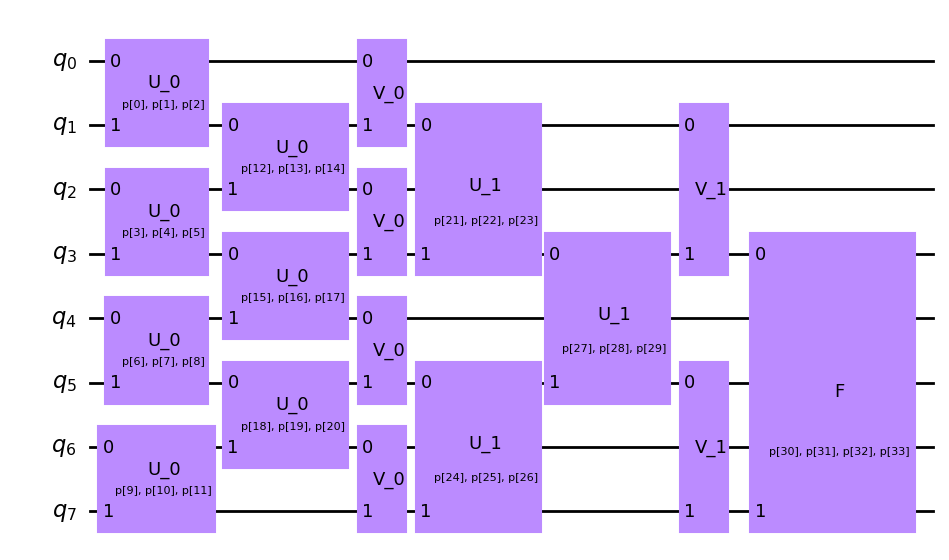

In [18]:
qubits = 8
train_set_size = 64
#-------------------------------------------------------------------------------------------------------------------------------------------
#QCNN feature map with no controlled rotation in convolution layer but with cx for entangling, in fully connected: every qubit rotates differently
qcnn_train = qcnn_feature_map(qubits)

x = ParameterVector("x",3)
conv_gate1 = QuantumCircuit(2)
conv_gate1.rx(x[0],0)
conv_gate1.cx(0,1)
conv_gate1.rx(x[1],1)
conv_gate1.cx(1,0)
conv_gate1.ry(x[2],0)

pool_gate = QuantumCircuit(2)
pool_gate.cy(1,0)

f = ParameterVector("f",4)
fully_gate = QuantumCircuit(2)
fully_gate.crz(f[0],0,1)
fully_gate.rx(f[1],0)
fully_gate.rx(f[2],1)
fully_gate.crz(f[3],1,0)

qcnn_train.convolution(conv_gate1,entangled=True,var_param=True)
qcnn_train.pooling(pool_gate)
qcnn_train.convolution(conv_gate1,entangled=True,var_param=True)
qcnn_train.pooling(pool_gate)
qcnn_train.fully_connected(fully_gate)

param_vec_for_qcnn = ParameterVector("p", qcnn_train.num_parameters)
qcnn_train.get_circuit([],param_vec_for_qcnn).draw()
#-------------------------------------------------------------------------------------------------------------------------------------------

10 qubit examples

[3, 7, 9]
42


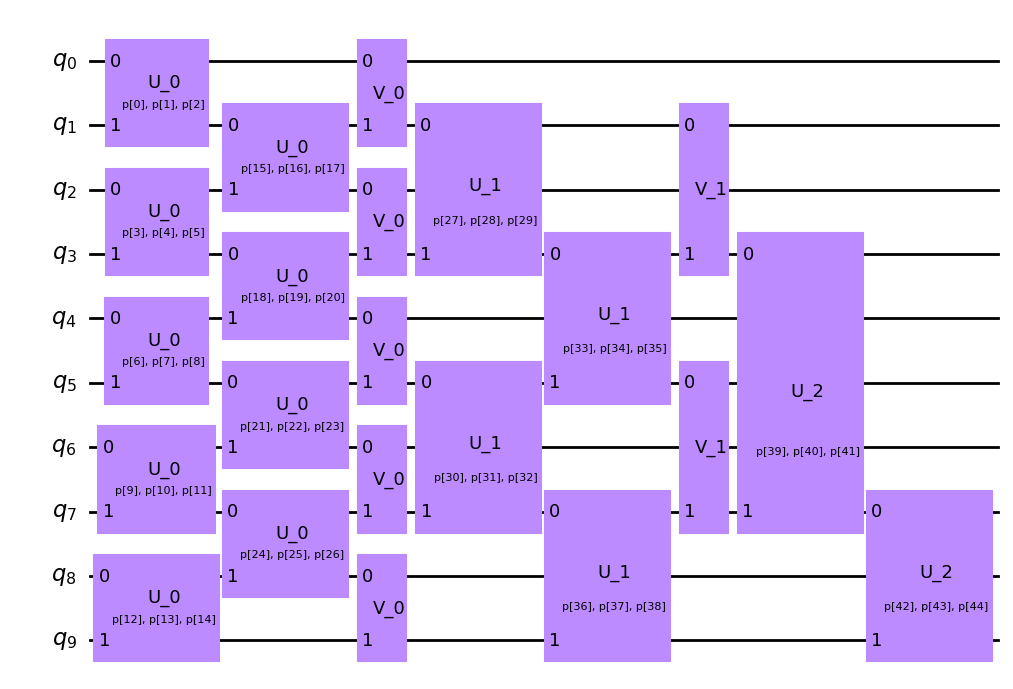

In [28]:
qubits = 10
train_set_size = 64
#-------------------------------------------------------------------------------------------------------------------------------------------
#QCNN feature map with no controlled rotation in convolution layer but with cx for entangling, in fully connected: every qubit rotates differently
qcnn_train = qcnn_feature_map(qubits)

x = ParameterVector("x",3)
conv_gate1 = QuantumCircuit(2)
conv_gate1.rx(x[0],0)
conv_gate1.cx(0,1)
conv_gate1.rx(x[1],1)
conv_gate1.cx(1,0)
conv_gate1.ry(x[2],0)

pool_gate = QuantumCircuit(2)
pool_gate.cy(1,0)

f = ParameterVector("f",4)
fully_gate = QuantumCircuit(2)
fully_gate.crz(f[0],0,1)
fully_gate.rx(f[1],0)
fully_gate.rx(f[2],1)
fully_gate.crz(f[3],1,0)

qcnn_train.convolution(conv_gate1,entangled=True,var_param=True)
qcnn_train.pooling(pool_gate)
qcnn_train.convolution(conv_gate1,entangled=True,var_param=True)
qcnn_train.pooling(pool_gate)
qcnn_train.convolution(conv_gate1,entangled=True,var_param=True)
# qcnn_train.pooling(pool_gate)
#qcnn_train.fully_connected(fully_gate)
print(qcnn_train.get_qubits_left())
param_vec_for_qcnn = ParameterVector("p", 45)
print(qcnn_train.num_parameters)
qcnn_train.get_circuit([],param_vec_for_qcnn).draw()
#-------------------------------------------------------------------------------------------------------------------------------------------